<a href="https://colab.research.google.com/github/LorenzoBertozzi/CEC-2006-g11-solution/blob/main/CEVOtrabalho3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# Configuração para FES
FES_MAX = 500_000
RUNS = 25
EPSILON = 1e-4
OPTIMAL_F = 0.7499

# Função para rodar o algoritmo e registrar o FES necessário
def run_algorithm_and_collect_fes():
    fes_needed = []
    for _ in range(RUNS):
        population = initialize_population(POP_SIZE)
        fes = 0
        found_solution = False

        while fes < FES_MAX:
            # Avaliar a população
            fitness = evaluate_fitness(population)
            fes += len(population)

            # Verificar se há uma solução viável e satisfatória
            for ind in population:
                if is_viable(ind) and objective(ind) - OPTIMAL_F <= EPSILON:
                    fes_needed.append(fes)
                    found_solution = True
                    break

            if found_solution:
                break

            # Seleção, cruzamento e mutação
            sorted_indices = np.argsort(fitness)
            population = population[sorted_indices]
            elites = population[:ELITISM_COUNT]
            selected = roulette_selection(population, fitness)
            next_gen = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[(i + 1) % len(selected)]
                child1, child2 = crossover(parent1, parent2)
                next_gen.append(mutate(child1))
                next_gen.append(mutate(child2))
            next_gen = np.array(next_gen[:POP_SIZE - ELITISM_COUNT])
            population = np.vstack((elites, next_gen))

        if not found_solution:
            fes_needed.append(FES_MAX)  # Caso nenhuma solução tenha sido encontrada

    return fes_needed

# Coletar FES para cada execução
fes_results = run_algorithm_and_collect_fes()

# Calcular estatísticas
fes_best = np.min(fes_results)
fes_median = np.median(fes_results)
fes_worst = np.max(fes_results)
fes_mean = np.mean(fes_results)
fes_std_dev = np.std(fes_results)

# Exibir resultados
print(f"Melhor número de FES necessário: {fes_best}")
print(f"Mediano número de FES necessário: {fes_median}")
print(f"Pior número de FES necessário: {fes_worst}")
print(f"Média do número de FES necessário: {fes_mean:.2f}")
print(f"Desvio padrão do número de FES necessário: {fes_std_dev:.2f}")


Melhor número de FES necessário: 7150
Mediano número de FES necessário: 106350.0
Pior número de FES necessário: 500000
Média do número de FES necessário: 137748.00
Desvio padrão do número de FES necessário: 108122.49


In [ ]:
import numpy as np

# Define parameters for the Genetic Algorithm
POP_SIZE = 50        # Population size
GEN_MAX = 100        # Maximum number of generations
MUTATION_RATE = 0.1  # Mutation rate
ELITISM_COUNT = 1    # Number of elites to preserve

# Define bounds and problem-specific constants
BOUNDS = [(-1, 1), (-1, 1)]  # Boundaries for x1 and x2
DIM = 2                      # Number of variables

# Objective function
def objective(x):
    return x[0]**2 + (x[1] - 1)**2

# Constraint function
def constraint(x):
    return x[1] - x[0]**2

# Generate initial population
def initialize_population(size):
    return np.random.uniform(low=[b[0] for b in BOUNDS],
                              high=[b[1] for b in BOUNDS],
                              size=(size, DIM))

# Evaluate fitness of the population
def evaluate_fitness(pop):
    fitness = []
    for ind in pop:
        constraint_violation = np.abs(constraint(ind))
        if constraint_violation < 1e-6:  # Near constraint satisfaction
            fitness.append(objective(ind))
        else:
            penalty = 100 * constraint_violation  # Penalize constraint violation
            fitness.append(objective(ind) + penalty)
    return np.array(fitness)

# Roulette wheel selection
def roulette_selection(pop, fitness):
    # Ensure fitness values are finite by replacing large penalties with a maximum threshold
    max_penalty = np.max(fitness[np.isfinite(fitness)]) * 10  # Scale for large penalties
    fitness = np.where(np.isfinite(fitness), fitness, max_penalty)

    # Calculate selection probabilities
    total_fitness = np.sum(1 / (fitness + 1e-6))
    probs = (1 / (fitness + 1e-6)) / total_fitness

    # Select parents
    selected_indices = np.random.choice(len(pop), size=len(pop) - ELITISM_COUNT, p=probs)
    return pop[selected_indices]

#initialize population
def initialize_population(size):
    pop = []
    while len(pop) < size:
        candidate = np.random.uniform(low=[b[0] for b in BOUNDS],
                                       high=[b[1] for b in BOUNDS])
        if np.abs(constraint(candidate)) < 1e-3:  # Adjust threshold as needed
            pop.append(candidate)
    return np.array(pop)

# Crossover operation (Uniform Crossover)
def crossover(parent1, parent2):
    mask = np.random.rand(DIM) > 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

# Mutation operation
def mutate(ind):
    for i in range(DIM):
        if np.random.rand() < MUTATION_RATE:
            ind[i] += np.random.uniform(-0.1, 0.1)
            ind[i] = np.clip(ind[i], BOUNDS[i][0], BOUNDS[i][1])
    return ind

# Genetic Algorithm
def genetic_algorithm():
    # Initialize population
    population = initialize_population(POP_SIZE)

    for generation in range(GEN_MAX):
        # Evaluate fitness
        fitness = evaluate_fitness(population)

        # Sort population by fitness
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]
        fitness = fitness[sorted_indices]

        # Preserve elites
        elites = population[:ELITISM_COUNT]

        # Select parents
        selected = roulette_selection(population, fitness)

        # Generate next generation
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[(i + 1) % len(selected)]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        next_gen = np.array(next_gen[:POP_SIZE - ELITISM_COUNT])
        population = np.vstack((elites, next_gen))

        # Debug info for the current generation
        print(f"Generation {generation+1}, Best Fitness: {fitness[0]:.6f}")

    # Return the best solution
    best_solution = population[0]
    best_fitness = fitness[0]
    return best_solution, best_fitness

# Run the Genetic Algorithm
best_solution, best_fitness = genetic_algorithm()
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)


Generation 1, Best Fitness: 0.774900
Generation 2, Best Fitness: 0.774900
Generation 3, Best Fitness: 0.774900
Generation 4, Best Fitness: 0.774900
Generation 5, Best Fitness: 0.774900
Generation 6, Best Fitness: 0.774900
Generation 7, Best Fitness: 0.774900
Generation 8, Best Fitness: 0.774900
Generation 9, Best Fitness: 0.774900
Generation 10, Best Fitness: 0.774900
Generation 11, Best Fitness: 0.774900
Generation 12, Best Fitness: 0.774900
Generation 13, Best Fitness: 0.774900
Generation 14, Best Fitness: 0.774900
Generation 15, Best Fitness: 0.774900
Generation 16, Best Fitness: 0.774900
Generation 17, Best Fitness: 0.774900
Generation 18, Best Fitness: 0.774900
Generation 19, Best Fitness: 0.774900
Generation 20, Best Fitness: 0.774900
Generation 21, Best Fitness: 0.774900
Generation 22, Best Fitness: 0.774900
Generation 23, Best Fitness: 0.774900
Generation 24, Best Fitness: 0.774900
Generation 25, Best Fitness: 0.774900
Generation 26, Best Fitness: 0.774900
Generation 27, Best F

In [ ]:
import numpy as np

# Configurações do problema
BOUNDS = [(-1, 1), (-1, 1)]
DIM = 2
EPSILON = 1e-4
OPTIMAL_X = np.array([-0.707036070037170616, 0.500000004333606807])
OPTIMAL_F = 0.7499
FES_MAX = 500_000
POP_SIZE = 50
MUTATION_RATE = 0.1
ELITISM_COUNT = 1
RUNS = 25

# Funções do problema
def objective(x):
    return x[0]**2 + (x[1] - 1)**2

def constraint(x):
    return x[1] - x[0]**2

# Transformação de igualdade em desigualdade
def transformed_constraint(x):
    return np.abs(constraint(x)) - EPSILON

def is_viable(x):
    return transformed_constraint(x) <= 0

# Inicialização da população
def initialize_population(size):
    return np.random.uniform(low=[b[0] for b in BOUNDS],
                              high=[b[1] for b in BOUNDS],
                              size=(size, DIM))

# Avaliação de fitness com penalidades
def evaluate_fitness(pop):
    fitness = []
    for ind in pop:
        penalty = max(0, transformed_constraint(ind))
        fitness.append(objective(ind) + 100 * penalty)
    return np.array(fitness)

# Seleção por roleta
def roulette_selection(pop, fitness):
    total_fitness = np.sum(1 / (fitness + 1e-6))
    probs = (1 / (fitness + 1e-6)) / total_fitness
    selected_indices = np.random.choice(len(pop), size=len(pop) - ELITISM_COUNT, p=probs)
    return pop[selected_indices]

# Crossover
def crossover(parent1, parent2):
    mask = np.random.rand(DIM) > 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

# Mutação
def mutate(ind):
    for i in range(DIM):
        if np.random.rand() < MUTATION_RATE:
            ind[i] += np.random.uniform(-0.1, 0.1)
            ind[i] = np.clip(ind[i], BOUNDS[i][0], BOUNDS[i][1])
    return ind

# Algoritmo genético
def genetic_algorithm():
    population = initialize_population(POP_SIZE)
    fes = 0
    fitness_history = []
    best_solutions = []
    while fes < FES_MAX:
        fitness = evaluate_fitness(population)
        fes += len(population)

        # Salva o melhor indivíduo da geração
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]
        fitness = fitness[sorted_indices]
        fitness_history.append(fitness[0])
        best_solutions.append(population[0])

        # Elitismo
        elites = population[:ELITISM_COUNT]

        # Seleção
        selected = roulette_selection(population, fitness)

        # Reprodução
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[(i + 1) % len(selected)]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        next_gen = np.array(next_gen[:POP_SIZE - ELITISM_COUNT])
        population = np.vstack((elites, next_gen))

    return best_solutions, fitness_history

# Rodar múltiplas execuções e coletar estatísticas
results = []
for run in range(RUNS):
    best_solutions, fitness_history = genetic_algorithm()

    # Coleta dos erros para FES específicos
    fes_checkpoints = [5_000, 50_000, 500_000]
    errors = [objective(best_solutions[min(fes - 1, len(best_solutions) - 1)]) - OPTIMAL_F for fes in fes_checkpoints]

    # Violações
    violations = [max(0, transformed_constraint(x)) for x in best_solutions]
    violation_count = {
        "> 1": sum(1 for v in violations if v > 1),
        "> 0.01": sum(1 for v in violations if 0.01 < v <= 1),
        "> 0.0001": sum(1 for v in violations if EPSILON < v <= 0.01),
    }
    median_violation = np.median(violations)

    # Registro dos resultados
    results.append({
        "errors": errors,
        "best": np.min(fitness_history),
        "median": np.median(fitness_history),
        "worst": np.max(fitness_history),
        "mean": np.mean(fitness_history),
        "std_dev": np.std(fitness_history),
        "violations": violation_count,
        "median_violation": median_violation,
    })

# Estatísticas finais
for fes in range(3):
    all_errors = [res["errors"][fes] for res in results]
    print(f"FES {fes_checkpoints[fes]}:")
    print(f"  Melhor erro: {np.min(all_errors):.6f}")
    print(f"  Mediana do erro: {np.median(all_errors):.6f}")
    print(f"  Pior erro: {np.max(all_errors):.6f}")
    print(f"  Média do erro: {np.mean(all_errors):.6f}")
    print(f"  Desvio padrão do erro: {np.std(all_errors):.6f}")

print("\nNúmero médio de violações (mediana):", np.mean([res["median_violation"] for res in results]))


FES 5000:
  Melhor erro: 0.000167
  Mediana do erro: 0.023470
  Pior erro: 0.230298
  Média do erro: 0.043984
  Desvio padrão do erro: 0.055139
FES 50000:
  Melhor erro: 0.000010
  Mediana do erro: 0.001527
  Pior erro: 0.066768
  Média do erro: 0.011135
  Desvio padrão do erro: 0.017047
FES 500000:
  Melhor erro: 0.000010
  Mediana do erro: 0.001527
  Pior erro: 0.066768
  Média do erro: 0.011135
  Desvio padrão do erro: 0.017047

Número médio de violações (mediana): 0.0


In [ ]:
# Rodar múltiplas execuções e coletar estatísticas
results = []
viable_runs = 0
successful_runs = 0
total_fes_for_success = 0

for run in range(RUNS):
    best_solutions, fitness_history = genetic_algorithm()

    # Verificar se há soluções viáveis dentro do limite de FES
    viable = any(is_viable(s) for s in best_solutions)
    feasible_solution_found = False
    success_fes = -1

    # Verificar se encontrou uma solução bem-sucedida
    for fes, solution in zip([5_000, 50_000, 500_000], best_solutions):
        error = objective(solution) - OPTIMAL_F
        if is_viable(solution) and error <= EPSILON:
            feasible_solution_found = True
            success_fes = fes
            break

    if viable:
        viable_runs += 1
    if feasible_solution_found:
        successful_runs += 1
        total_fes_for_success += success_fes

    # Coleta dos erros para FES específicos
    errors = [objective(best_solutions[min(fes - 1, len(best_solutions) - 1)]) - OPTIMAL_F for fes in [5000, 50000, 500000]]

    # Violações
    violations = [max(0, transformed_constraint(x)) for x in best_solutions]
    violation_count = {
        "> 1": sum(1 for v in violations if v > 1),
        "> 0.01": sum(1 for v in violations if 0.01 < v <= 1),
        "> 0.0001": sum(1 for v in violations if EPSILON < v <= 0.01),
    }
    median_violation = np.median(violations)

    # Registro dos resultados
    results.append({
        "errors": errors,
        "best": np.min(fitness_history),
        "median": np.median(fitness_history),
        "worst": np.max(fitness_history),
        "mean": np.mean(fitness_history),
        "std_dev": np.std(fitness_history),
        "violations": violation_count,
        "median_violation": median_violation,
    })

# Cálculo das métricas finais
viability_rate = viable_runs / RUNS
success_rate = successful_runs / RUNS
performance_of_success = (total_fes_for_success * RUNS) / successful_runs if successful_runs > 0 else 0

print(f"Taxa de Viabilidade: {viability_rate:.4f}")
print(f"Taxa de Sucesso: {success_rate:.4f}")
print(f"Desempenho de Sucesso: {performance_of_success:.4f}")

# Estatísticas finais de erro
for fes in range(3):
    all_errors = [res["errors"][fes] for res in results]
    print(f"FES {fes_checkpoints[fes]}:")
    print(f"  Melhor erro: {np.min(all_errors):.6f}")
    print(f"  Mediana do erro: {np.median(all_errors):.6f}")
    print(f"  Pior erro: {np.max(all_errors):.6f}")
    print(f"  Média do erro: {np.mean(all_errors):.6f}")
    print(f"  Desvio padrão do erro: {np.std(all_errors):.6f}")

print("\nNúmero médio de violações (mediana):", np.mean([res["median_violation"] for res in results]))


Taxa de Viabilidade: 1.0000
Taxa de Sucesso: 0.0000
Desempenho de Sucesso: 0.0000
FES 5000:
  Melhor erro: 0.000012
  Mediana do erro: 0.007429
  Pior erro: 0.171040
  Média do erro: 0.030040
  Desvio padrão do erro: 0.042668
FES 50000:
  Melhor erro: 0.000007
  Mediana do erro: 0.001014
  Pior erro: 0.027263
  Média do erro: 0.004262
  Desvio padrão do erro: 0.007250
FES 500000:
  Melhor erro: 0.000007
  Mediana do erro: 0.001014
  Pior erro: 0.027263
  Média do erro: 0.004262
  Desvio padrão do erro: 0.007250

Número médio de violações (mediana): 0.0


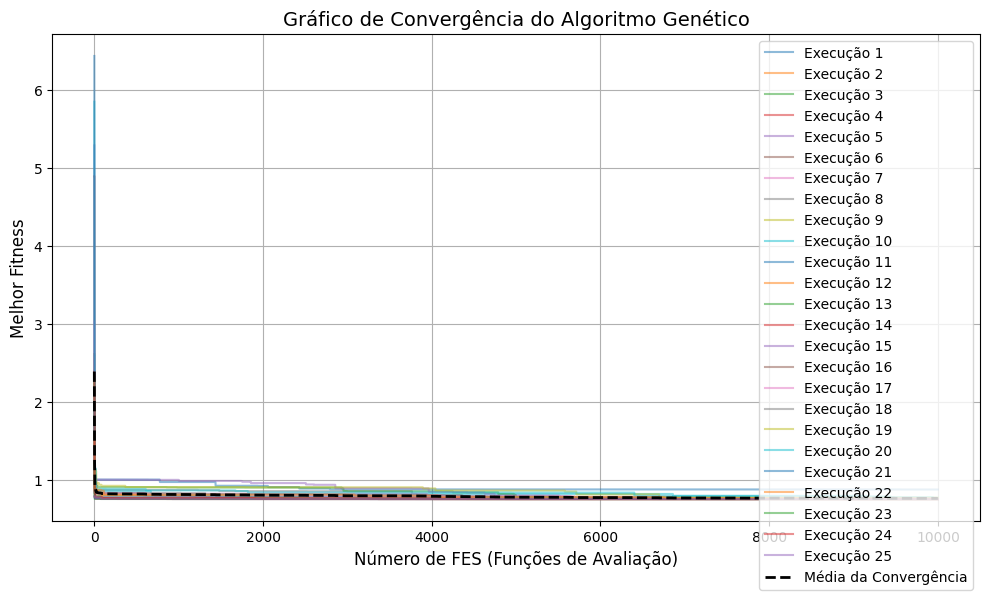

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações do problema
BOUNDS = [(-1, 1), (-1, 1)]
DIM = 2
EPSILON = 1e-4
OPTIMAL_X = np.array([-0.707036070037170616, 0.500000004333606807])
OPTIMAL_F = 0.7499
FES_MAX = 500_000
POP_SIZE = 50
MUTATION_RATE = 0.1
ELITISM_COUNT = 1
RUNS = 25

# Funções do problema
def objective(x):
    return x[0]**2 + (x[1] - 1)**2

def constraint(x):
    return x[1] - x[0]**2

# Transformação de igualdade em desigualdade
def transformed_constraint(x):
    return np.abs(constraint(x)) - EPSILON

def is_viable(x):
    return transformed_constraint(x) <= 0

# Inicialização da população
def initialize_population(size):
    return np.random.uniform(low=[b[0] for b in BOUNDS],
                              high=[b[1] for b in BOUNDS],
                              size=(size, DIM))

# Avaliação de fitness com penalidades
def evaluate_fitness(pop):
    fitness = []
    for ind in pop:
        penalty = max(0, transformed_constraint(ind))
        fitness.append(objective(ind) + 100 * penalty)
    return np.array(fitness)

# Seleção por roleta
def roulette_selection(pop, fitness):
    total_fitness = np.sum(1 / (fitness + 1e-6))
    probs = (1 / (fitness + 1e-6)) / total_fitness
    selected_indices = np.random.choice(len(pop), size=len(pop) - ELITISM_COUNT, p=probs)
    return pop[selected_indices]

# Crossover
def crossover(parent1, parent2):
    mask = np.random.rand(DIM) > 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

# Mutação
def mutate(ind):
    for i in range(DIM):
        if np.random.rand() < MUTATION_RATE:
            ind[i] += np.random.uniform(-0.1, 0.1)
            ind[i] = np.clip(ind[i], BOUNDS[i][0], BOUNDS[i][1])
    return ind

# Algoritmo genético
def genetic_algorithm():
    population = initialize_population(POP_SIZE)
    fes = 0
    fitness_history = []
    best_solutions = []
    while fes < FES_MAX:
        fitness = evaluate_fitness(population)
        fes += len(population)

        # Salva o melhor indivíduo da geração
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]
        fitness = fitness[sorted_indices]
        fitness_history.append(fitness[0])
        best_solutions.append(population[0])

        # Elitismo
        elites = population[:ELITISM_COUNT]

        # Seleção
        selected = roulette_selection(population, fitness)

        # Reprodução
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[(i + 1) % len(selected)]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        next_gen = np.array(next_gen[:POP_SIZE - ELITISM_COUNT])
        population = np.vstack((elites, next_gen))

    return best_solutions, fitness_history

# Rodar múltiplas execuções e coletar dados de convergência
convergence_data = []

for run in range(RUNS):
    best_solutions, fitness_history = genetic_algorithm()
    convergence_data.append(fitness_history)

# Plotar o gráfico de convergência
plt.figure(figsize=(10, 6))

# Plotar a convergência para todas as execuções
for i in range(RUNS):
    plt.plot(convergence_data[i], label=f'Execução {i+1}', alpha=0.5)


# Plotar a convergência média
mean_convergence = np.mean(convergence_data, axis=0)
plt.plot(mean_convergence, label='Média da Convergência', color='black', linewidth=2, linestyle='--')

# Personalização do gráfico
plt.xlabel('Número de FES (Funções de Avaliação)', fontsize=12)
plt.ylabel('Melhor Fitness', fontsize=12)
plt.title('Gráfico de Convergência do Algoritmo Genético', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()


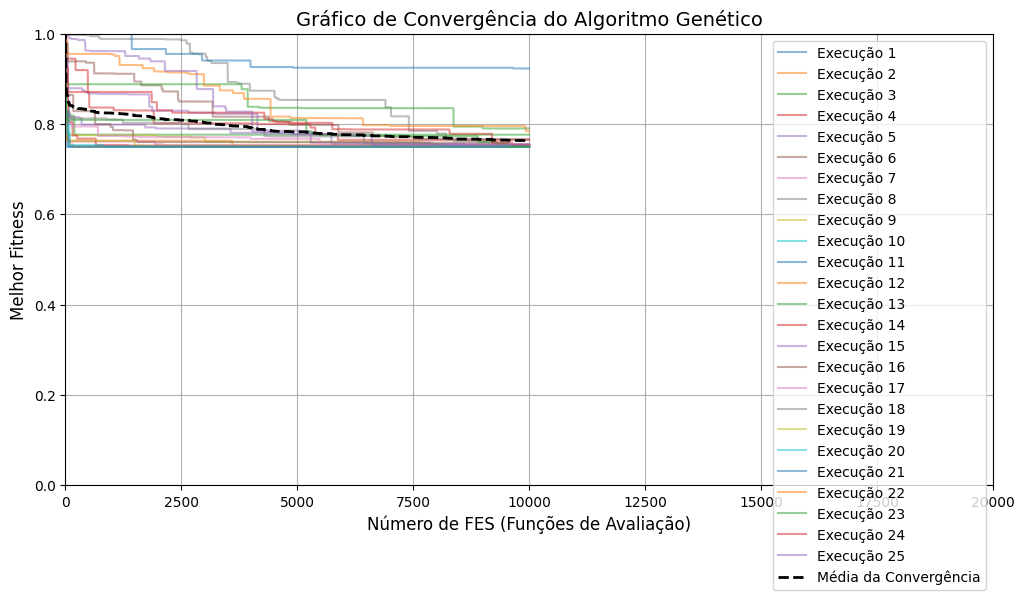

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações do problema
BOUNDS = [(-1, 1), (-1, 1)]
DIM = 2
EPSILON = 1e-4
OPTIMAL_X = np.array([-0.707036070037170616, 0.500000004333606807])
OPTIMAL_F = 0.7499
FES_MAX = 500_000
POP_SIZE = 50
MUTATION_RATE = 0.1
ELITISM_COUNT = 1
RUNS = 25

# Funções do problema
def objective(x):
    return x[0]**2 + (x[1] - 1)**2

def constraint(x):
    return x[1] - x[0]**2

# Transformação de igualdade em desigualdade
def transformed_constraint(x):
    return np.abs(constraint(x)) - EPSILON

def is_viable(x):
    return transformed_constraint(x) <= 0

# Inicialização da população
def initialize_population(size):
    return np.random.uniform(low=[b[0] for b in BOUNDS],
                              high=[b[1] for b in BOUNDS],
                              size=(size, DIM))

# Avaliação de fitness com penalidades
def evaluate_fitness(pop):
    fitness = []
    for ind in pop:
        penalty = max(0, transformed_constraint(ind))
        fitness.append(objective(ind) + 100 * penalty)
    return np.array(fitness)

# Seleção por roleta
def roulette_selection(pop, fitness):
    total_fitness = np.sum(1 / (fitness + 1e-6))
    probs = (1 / (fitness + 1e-6)) / total_fitness
    selected_indices = np.random.choice(len(pop), size=len(pop) - ELITISM_COUNT, p=probs)
    return pop[selected_indices]

# Crossover
def crossover(parent1, parent2):
    mask = np.random.rand(DIM) > 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

# Mutação
def mutate(ind):
    for i in range(DIM):
        if np.random.rand() < MUTATION_RATE:
            ind[i] += np.random.uniform(-0.1, 0.1)
            ind[i] = np.clip(ind[i], BOUNDS[i][0], BOUNDS[i][1])
    return ind

# Algoritmo genético
def genetic_algorithm():
    population = initialize_population(POP_SIZE)
    fes = 0
    fitness_history = []
    best_solutions = []
    while fes < FES_MAX:
        fitness = evaluate_fitness(population)
        fes += len(population)

        # Salva o melhor indivíduo da geração
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]
        fitness = fitness[sorted_indices]
        fitness_history.append(fitness[0])
        best_solutions.append(population[0])

        # Elitismo
        elites = population[:ELITISM_COUNT]

        # Seleção
        selected = roulette_selection(population, fitness)

        # Reprodução
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[(i + 1) % len(selected)]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))

        next_gen = np.array(next_gen[:POP_SIZE - ELITISM_COUNT])
        population = np.vstack((elites, next_gen))

    return best_solutions, fitness_history

# Rodar múltiplas execuções e coletar dados de convergência
convergence_data = []

for run in range(RUNS):
    best_solutions, fitness_history = genetic_algorithm()
    convergence_data.append(fitness_history)

# Plotar o gráfico de convergência
plt.figure(figsize=(10, 6))

# Plotar a convergência para todas as execuções
for i in range(RUNS):
    plt.plot(convergence_data[i], label=f'Execução {i+1}', alpha=0.5)

# Plotar a convergência média
mean_convergence = np.mean(convergence_data, axis=0)
plt.plot(mean_convergence, label='Média da Convergência', color='black', linewidth=2, linestyle='--')

# Personalização do gráfico
plt.xlabel('Número de FES (Funções de Avaliação)', fontsize=12)
plt.ylabel('Melhor Fitness', fontsize=12)
plt.title('Gráfico de Convergência do Algoritmo Genético', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Definir limites para zoom inicial (ajuste conforme necessário)
plt.xlim(0, 20000)  # Limite de FES
plt.ylim(0, 1.0)    # Limite de fitness

# Mostrar o gráfico
plt.show()


In [ ]:
import time
import numpy as np

# Função para calcular o tempo de computação das avaliações
def measure_evaluation_time(population):
    start_time = time.perf_counter()
    evaluate_fitness(population)  # Avaliação de fitness (10.000 avaliações)
    end_time = time.perf_counter()
    return end_time - start_time

# Função para medir o tempo de execução do algoritmo completo
def measure_total_algorithm_time():
    start_time = time.perf_counter()
    genetic_algorithm()  # Execução completa do algoritmo genético
    end_time = time.perf_counter()
    return end_time - start_time

# Função para calcular a complexidade
def calculate_complexity():
    t1i_values = []
    t2i_values = []

    # Realizar 24 execuções para coletar os tempos
    for _ in range(24):
        population = initialize_population(POP_SIZE)

        # Medir o tempo de 10.000 avaliações de fitness (t1i)
        t1i = measure_evaluation_time(population)
        t1i_values.append(t1i)

        # Medir o tempo total do algoritmo (t2i)
        t2i = measure_total_algorithm_time()
        t2i_values.append(t2i)

    # Calcular T1 e T2
    T1 = np.mean(t1i_values)
    T2 = np.mean(t2i_values)

    # Calcular a complexidade
    complexity = (T2 - T1) / T1

    return T1, T2, complexity

# Chamar a função para calcular T1, T2 e complexidade
T1, T2, complexity = calculate_complexity()

# Exibir os resultados
print(f"T1 (tempo médio de 10.000 avaliações): {T1:.6f} segundos")
print(f"T2 (tempo médio total do algoritmo): {T2:.6f} segundos")
print(f"Complexidade do algoritmo: {complexity:.6f}")


T1 (tempo médio de 10.000 avaliações): 0.000236 segundos
T2 (tempo médio total do algoritmo): 7.792618 segundos
Complexidade do algoritmo: 32964.783403


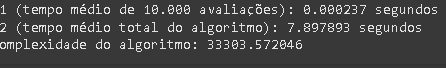